In [1]:
import numpy as np
from modules.preprocessing.file_creation import create_mat_files
from modules.feature_extraction.feature_extraction import get_psd_feature_vectors
from modules.training.training import train_clf_and_get_metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from matplotlib import pyplot as plt

Datos de Calibración

In [2]:
dict_cal = create_mat_files('./data/im_tention_signals', file_type='calibration')
dict_ter = create_mat_files('./data/im_tention_signals', file_type='therapy', mi_only=True, ther_number_of_trials=60)

Number of subjects found: 8
Number of MI calibration trials for subject1: 30
Number of MI calibration trials for subject2: 30
Number of MI calibration trials for subject3: 30
Number of MI calibration trials for subject4: 30
Number of MI calibration trials for subject5: 30
Number of MI calibration trials for subject6: 30
Number of MI calibration trials for subject7: 30
Number of MI calibration trials for subject8: 30
Number of subjects found: 8
Number of therapy trials for subject1: 60
Number of therapy trials for subject2: 60
Number of therapy trials for subject3: 60
Number of therapy trials for subject4: 60
Number of therapy trials for subject5: 60
Number of therapy trials for subject6: 60
Number of therapy trials for subject7: 60
Number of therapy trials for subject8: 60


In [3]:
s1_mi_rest = dict_cal['subject_1']['mi_rest']
s1_mi_rest.shape

(500, 5, 60)

In [4]:
y_calibration = np.hstack((np.ones(s1_mi_rest.shape[2]//2, dtype=np.int8), np.zeros(s1_mi_rest.shape[2]//2, dtype=np.int8)))
y_calibration.shape

(60,)

In [5]:
y_therapy = np.array([i%2 for i in range(1, 60 + 1)])
y_therapy.shape

(60,)

### PSD de datos de calibración

In [6]:
clasificadores_por_sujeto_lda = []
psd_matrix = {}
for i in range(8):
    psd_matrix[f's_{i+1}'] = get_psd_feature_vectors(dict_cal[f'subject_{i+1}']['mi_rest'])
    lda, metrics =train_clf_and_get_metrics(psd_matrix[f's_{i+1}'], y_calibration, clf=LinearDiscriminantAnalysis())
    clasificadores_por_sujeto_lda.append(lda)


In [7]:
psd_matrix['s_1'].shape

(60, 23)

### PSD de datos de terapia

In [8]:
psd_matrix_ter = {}
for i in range(8):
    psd_matrix_ter[f's_{i+1}'] = get_psd_feature_vectors(dict_ter[f'subject_{i+1}']['mi'])

In [9]:
psd_matrix_ter['s_1'].shape

(60, 23)

In [14]:

import math

def plot_class_histograms(data, target, nrows=None, ncols=None, figsize=(12,6)):

    n_classes = np.unique(target).shape[0]
    if nrows is None and ncols is None:
        nrows = data.shape[1]//2 + data.shape[1] % 2
        ncols = 2
        n_hist = data.shape[1]
    else:
        n_hist = nrows * ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    for ax, cnt in zip(axes.ravel(), range(n_hist)):
        min_val = math.floor( np.min(data[:, cnt]) )
        max_val = math.ceil( np.max(data[:, cnt]) )
        bins = np.linspace(min_val, max_val, 23)

        for label, color in zip( range(n_classes), ('blue', 'red') ):
            ax.hist( data[target == label, cnt], color=color, label=f"class {label}", bins=bins, alpha=0.5, edgecolor='k')
        ylims = ax.get_ylim()

        leg = ax.legend(loc='upper right', fancybox=True, fontsize=8)
        leg.get_frame().set_alpha(0.5)
        ax.set_ylim([0, max(ylims)+2])
        # hide axis ticks
        ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
        # remove axis spines
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)

        if cnt % 2 == 0:
            ax.set_ylabel('count')

    fig.tight_layout()
    plt.show()      

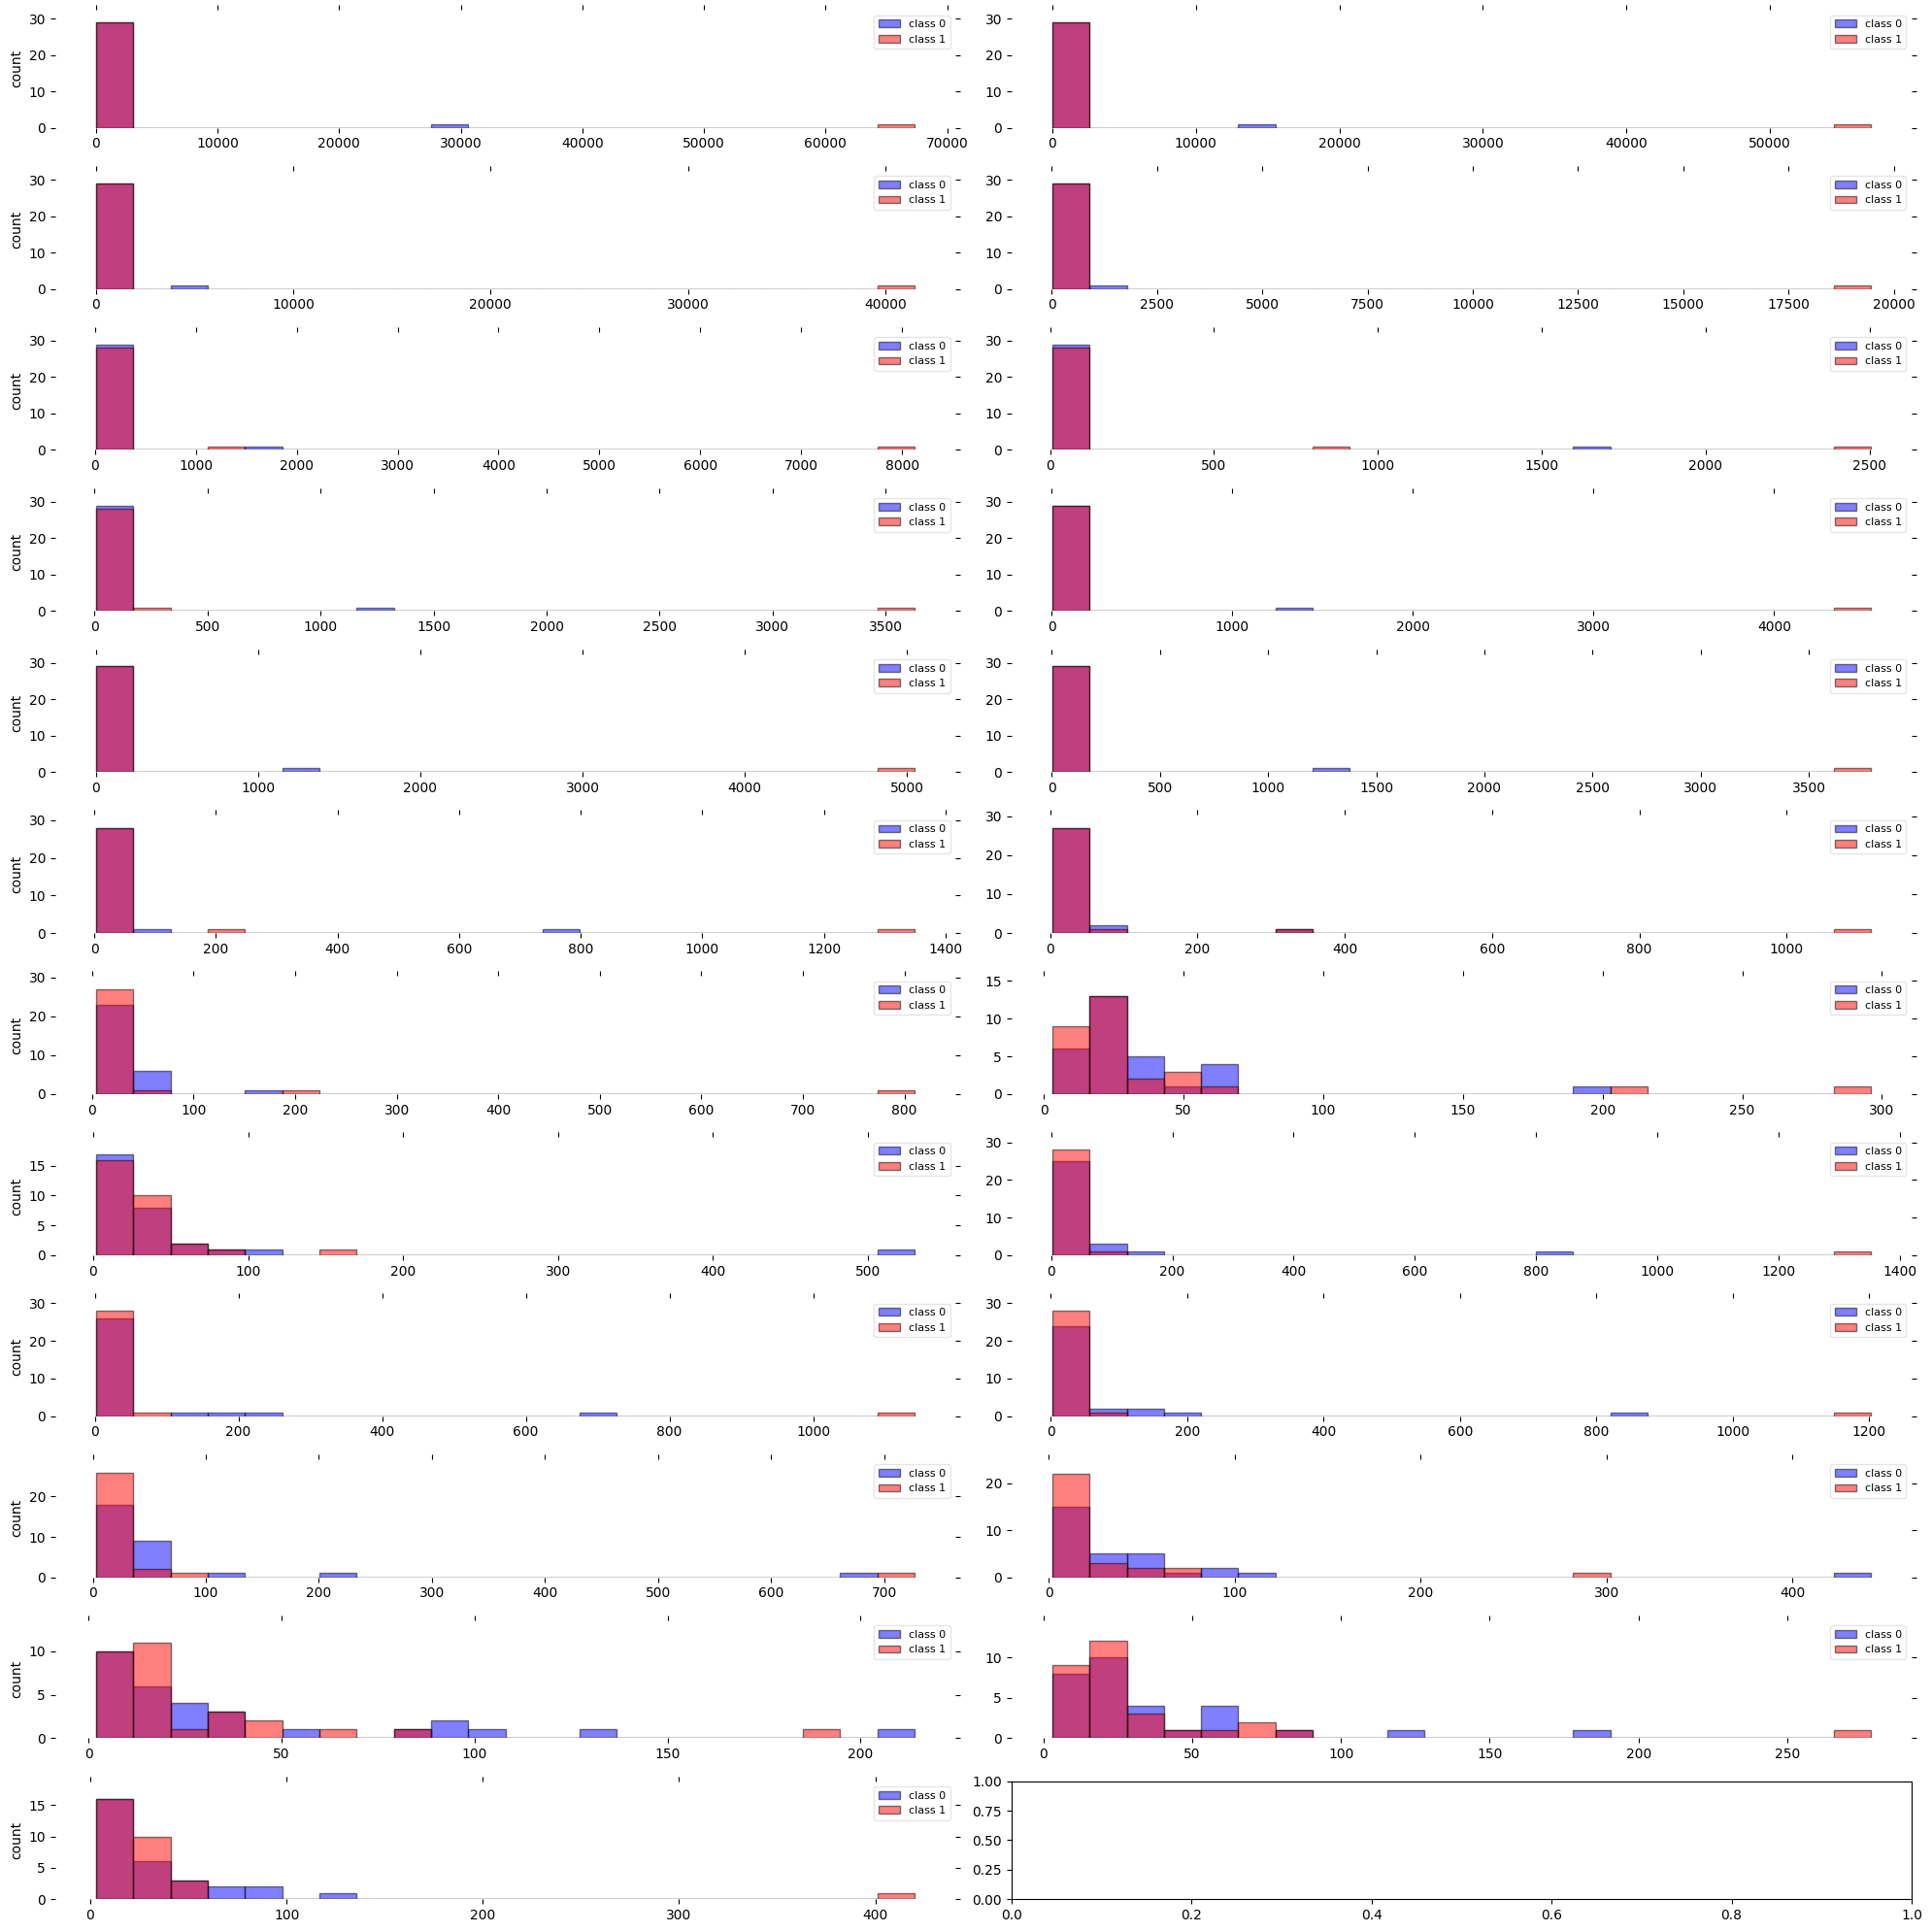

In [15]:
plot_class_histograms(psd_matrix['s_2'], y_calibration, figsize=(20, 20))

In [26]:
# La transformación LDA reduce la dimensión de los datos a 1
# X = lda.fit_transform(psd_matrix['s_1'], y_calibration)
X = np.dot(psd_matrix['s_1'], lda.coef_.T)
print("Dimensión de los datos transformados:", X.shape)

Dimensión de los datos transformados: (60, 1)


In [18]:
# Discriminante lineal
U = lda.coef_
print("Dimensión del discriminante lineal:", U.shape)
np.linalg.norm(lda.coef_)

Dimensión del discriminante lineal: (1, 23)


0.9908443087069079

In [19]:
#proyección ortogonal sobre el discriminante lineal para volver al espacio de las características R^23
X_proj = np.dot(X, U)
print("Dimensión de los datos proyectados:", X_proj.shape)

Dimensión de los datos proyectados: (60, 23)


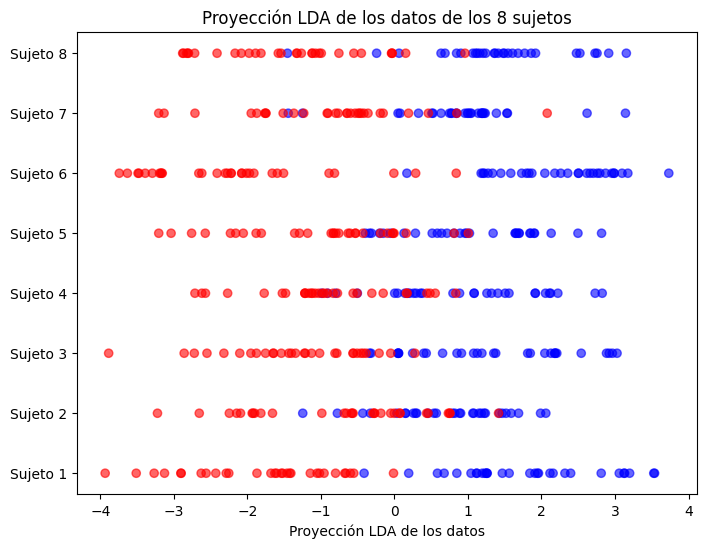

In [28]:
plt.figure(figsize=(8, 6))
for i in range(8):
    X_lda = lda.fit_transform(psd_matrix[f's_{i+1}'], y_calibration)
    X_ter_lda = lda.transform(psd_matrix_ter[f's_{i+1}'])
    colors = ['red' if label == 0 else 'blue' for label in y_calibration]
    plt.scatter(X_lda, np.full(shape=X_lda.shape, fill_value=i), c=colors, alpha=0.6)
    plt.xlabel('Proyección LDA de los datos')
    plt.title('Proyección LDA de los datos de los 8 sujetos')
plt.yticks(range(8), [f'Sujeto {i+1}' for i in range(8)])
plt.show()
